In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import os

In [2]:
import tensorflow as tf
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.__version__

'1.5.0'

In [4]:
image_path = "00003102d3ec9a46cb5cd2fd95473b8d.jpg"

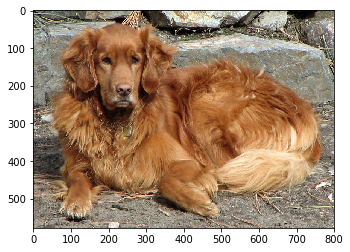

In [5]:
from PIL import Image
plt.imshow(Image.open(image_path))

In [6]:
ResNet50 = tf.keras.applications.ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input
image = tf.keras.preprocessing.image

In [7]:
resnet_model = ResNet50(weights='imagenet', include_top=False)

In [8]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return resnet_model.predict(x)[0][0][0]

In [9]:
f = extract_features(image_path)
print(f[:5])
print(len(f))

[0.03233024 0.05817406 0.37201637 0.         0.        ]
2048


In [58]:
size = 128

In [59]:
small_out = image.load_img(image_path, target_size=(size, size))

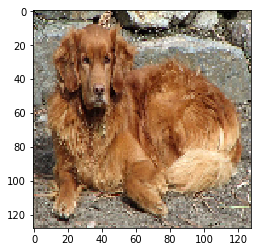

In [60]:
plt.imshow(small_out)

In [61]:
Input = tf.keras.layers.Input
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D
UpSampling2D = tf.keras.layers.UpSampling2D
Model = tf.keras.models.Model
Reshape = tf.keras.layers.Reshape
#from tf.keras import backend as K

In [62]:
input_img = Input(shape=(2048, ))  # adapt this if using `channels_first` image data format

x = Reshape([8, 8, 32] )(input_img)
x = Conv2D(1024, (4, 4), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (4, 4), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (4, 4), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (4, 4), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Conv2D(256, (16, 16), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(128, (32, 32), activation='relu')(x)
#x = UpSampling2D((2, 2))(x)
#decoded = Conv2D(3, (64, 64), activation='sigmoid', padding='same')(x)
decoded = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

In [63]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [64]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 2048)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 1024)        525312    
_________________________________________________________________
up_sampling2d_30 (UpSampling (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 512)       8389120   
_________________________________________________________________
up_sampling2d_31 (UpSampling (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 256)       2097408   
__________

In [ ]:
TensorBoard = tf.keras.callbacks.TensorBoard

autoencoder.fit(np.array([f[:2048]]), 
                #np.array([np.expand_dims(image.img_to_array(small_out), axis=0)]),
                np.reshape([image.img_to_array(small_out)], (1, size, size, 3)).astype('float32') / 255.,
                epochs=50,
               )
                #batch_size=128,
                #shuffle=True,
                #validation_data=(x_test, x_test),
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
1/1 [==============================]1/1 [==============================] - 2s 2s/step - loss: 0.6975

Epoch 2/50
1/1 [==============================]1/1 [==============================] - 1s 1s/step - loss: 0.6671

Epoch 3/50
1/1 [==============================]1/1 [==============================] - 2s 2s/step - loss: 0.6634

Epoch 4/50


In [ ]:
decoded_img = autoencoder.predict(np.array([f[:2048]]))
#plt.imshow(decoded_img.reshape(28, 28, 3))

In [ ]:
plt.figure(figsize=(28, 28))
plt.subplot(1, 2, 1)
plt.imshow(decoded_img.reshape(size, size, 3))
plt.title('Generated', fontsize=30)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(small_out)
plt.title('Original', fontsize=30)
plt.axis('off')
#plt.tight_layout()
plt.show()